# **1. Configuración del ambiente**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from bs4 import BeautifulSoup
# from datetime import date, timedelta

In [22]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

# **2. Obtención de los datos**

## **2.1 Precios Historicos del Bitcoin**

In [23]:
def importar_base_bitcoin():
  global df_bitcoin
  #Obteniendo datos historicos del Bitcoin
  df_bitcoin = yf.download('BTC-USD', period= '7d', interval='5m')

In [24]:
importar_base_bitcoin()
df_bitcoin.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-03-21 00:00:00+00:00,67882.164062,67882.164062,67784.882812,67784.882812,67784.882812,0
2024-03-21 00:05:00+00:00,67756.750000,67756.750000,67660.687500,67660.687500,67660.687500,0
2024-03-21 00:10:00+00:00,67900.546875,67900.546875,67806.250000,67834.539062,67834.539062,0
2024-03-21 00:15:00+00:00,67800.070312,67834.492188,67769.968750,67834.492188,67834.492188,0
2024-03-21 00:20:00+00:00,67867.492188,67892.710938,67753.289062,67753.289062,67753.289062,0


## **2.2 Extrayendo precio actual y tendencia del Bitcoin.**

In [25]:
def extraer_tendencias():
  global precio_actual, tendencia
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url)

  #Verificando que la busquedad fue un exito
  if respuesta.status_code == 200:
    s = BeautifulSoup(respuesta.content, 'lxml')

    #Obteniendo los span de la primera fila de la tabla de coinmarketcap.com
    html_row = s.findAll("tr")
    html_row = html_row[1]
    elementos = html_row.findAll("span")

    #Obteniendo el precio actual del Bitcoin en USD
    precio_actual = float(elementos[2].text.replace('$', '').replace(',',''))

    #Obteniendo  la tendencia
    if elementos[3].next.attrs['class'][0] == "icon-Caret-up":
      tendencia = 'Alta'
    else:
      tendencia = 'Baja'

  else:
    print("Error al cargar la página de CoinMarketCap")

In [26]:
extraer_tendencias()
print(f'Precio Actual: ${precio_actual} USD')
print(f'Tendencia: {tendencia}')

Precio Actual: $69863.64 USD
Tendencia: Alta


# **3. Limpieza de datos**

## **3.1 Análisis antes de la limpieza de datos**

In [27]:
# Creando copia del dataframe bitcoin
global df_bitcoin_limpio
df_bitcoin.drop('Adj Close', axis =1, inplace=True)
df_bitcoin_limpio = df_bitcoin.copy()

In [28]:
def analisis():
  global df_bitcoin_limpio
  indices_repetidos = df_bitcoin_limpio.duplicated().sum()
  valores_nulos_close = 'Si' if df_bitcoin_limpio.Close.isna().any() == True else "No"
  registros_cero = df_bitcoin_limpio.Volume[df_bitcoin_limpio.Volume <= 0].count()

  print(f'Existen {indices_repetidos} indices repetidos.')
  print(f'Existen valores nulos en la columna "Close": {valores_nulos_close}')
  print(f'Registros que tengan registros Volume de transacción menor o igual a cero: {registros_cero}')
analisis()

Existen 0 indices repetidos.
Existen valores nulos en la columna "Close": No
Registros que tengan registros Volume de transacción menor o igual a cero: 1044


In [29]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1831 entries, 2024-03-21 00:00:00+00:00 to 2024-03-27 08:30:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1831 non-null   float64
 1   High    1831 non-null   float64
 2   Low     1831 non-null   float64
 3   Close   1831 non-null   float64
 4   Volume  1831 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.8 KB


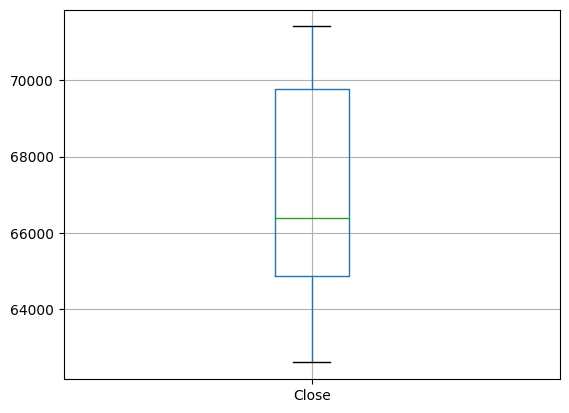

In [30]:
df_bitcoin_limpio.boxplot('Close');

## **3.2 Creación de la función que limpia la base de datos**

In [31]:
def limpieza_datos():
  global df_bitcoin, media_bitcoin, df_bitcoin_limpio
  #Creando una copia del dataframe original
  df_bitcoin_limpio = df_bitcoin.copy()

  # Eliminando valores respetidos del dataframe en caso de existir
  df_bitcoin_limpio.drop_duplicates(inplace=True)

  # Tratando los valores nulos de la columna close
  valores_nulos = df_bitcoin_limpio.Close.isna().any()
  if valores_nulos == True:
    df_bitcoin_limpio.Close.fillna(method='ffill', inplace=True)

  # Eliminado registros que tengan un Volume de transaccion igual cero
  query = df_bitcoin_limpio.query('Volume <= 0').index
  df_bitcoin_limpio.drop(query, axis = 0, inplace = True)

  # Seleccionado registro de la columna Close que esten entre Q1 y Q3
  Q1 = df_bitcoin_limpio.Close.quantile(0.25)
  Q3 = df_bitcoin_limpio.Close.quantile(0.75)
  # IIQ = Q3-Q1
  df_bitcoin_limpio = df_bitcoin_limpio.query(f'Close > {Q1} & Close < {Q3}')

  # Calculando la media con los datos ya filtrados.
  media_bitcoin = df_bitcoin_limpio.Close.mean()
  df_bitcoin

In [32]:
limpieza_datos()
analisis()
print(f'\nEl promedio del precio de Bitcoin es: {round(media_bitcoin,2)}')

Existen 0 indices repetidos.
Existen valores nulos en la columna "Close": No
Registros que tengan registros Volume de transacción menor o igual a cero: 0

El promedio del precio de Bitcoin es: 67105.7


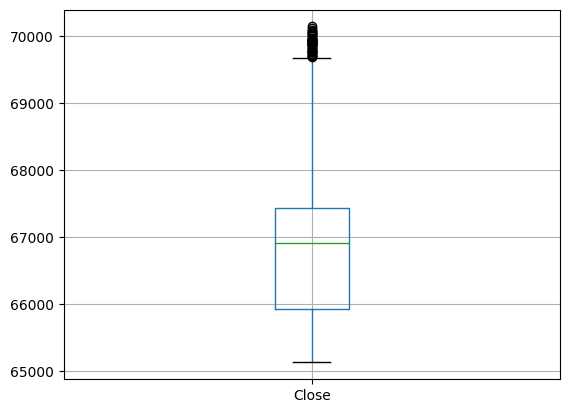

In [33]:
df_bitcoin_limpio.boxplot('Close');

# **4. Toma de decisiones**

In [34]:
def tomar_decision():
  global algoritmo_decision, tendencia, media_bitcoin, precio_actual

  if precio_actual >= media_bitcoin and tendencia == 'Baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'Alta':
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

In [35]:
tomar_decision()

# **5. Visualización**

In [36]:
def visualizacion():
  global df_bitcoin, media_bitcoin, algoritmo_decision
  # Añadiendo una nueva columna
  df_bitcoin['Promedio'] = media_bitcoin

  # Configuración del gráfico
  #plt.style.use("dark_background")
  plt.figure(figsize=(16,5))
  plt.title('Precio del Bitcoin en los ultimos 7 días')
  plt.plot(df_bitcoin.index, df_bitcoin.Close, linewidth = 0.85, color = 'black');
  plt.plot(df_bitcoin.index, df_bitcoin.Promedio, color = 'orange');
  plt.legend(['Precio Bitcoin', 'Promedio (7d)'])

  color = 'green' if algoritmo_decision == 'Vender' else 'blue' if algoritmo_decision == 'Comprar' else 'red'
  plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin.Close[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin.Close[-1]-1500),
             arrowprops=dict(facecolor=color, shrink=.1, width = 3, headwidth = 8), horizontalalignment='center')
  plt.show()


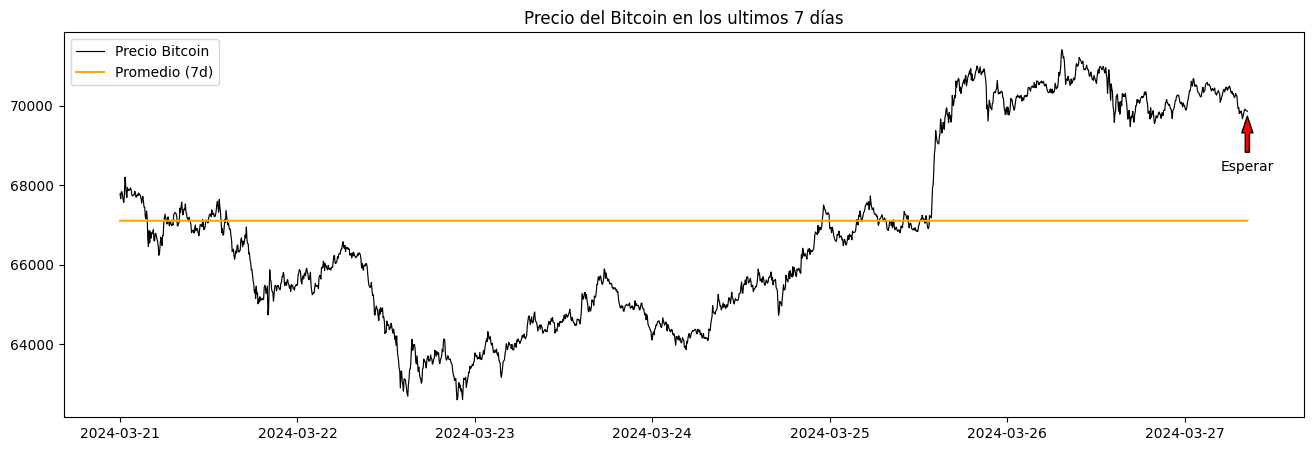

In [37]:
visualizacion()

## **6. Automatización**

In [38]:
from IPython.display import clear_output
import time

[*********************100%%**********************]  1 of 1 completed


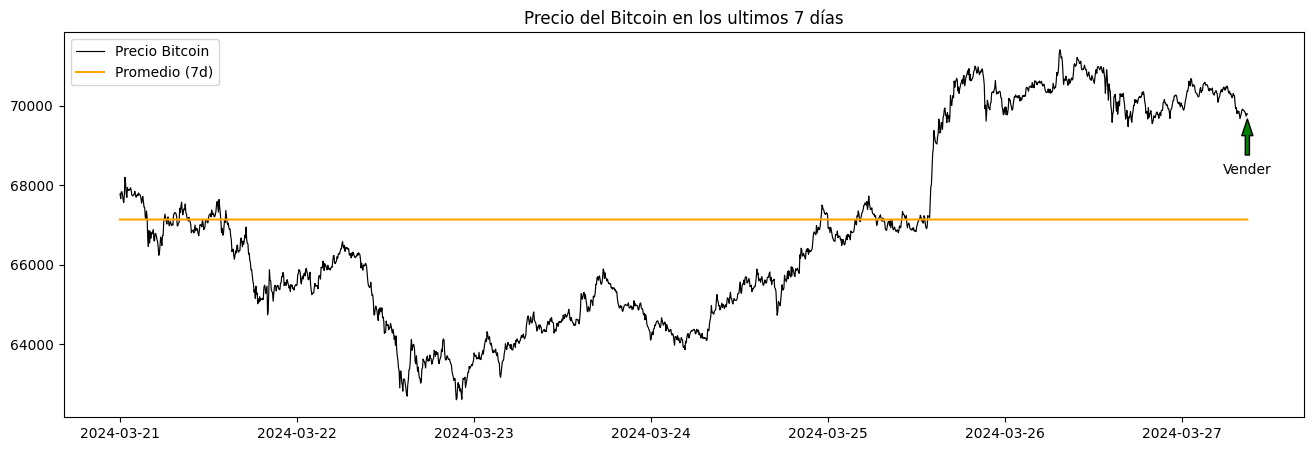

KeyboardInterrupt: 

In [39]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decision()
  visualizacion()
  time.sleep(300)